In [16]:
from __future__ import print_function, division, absolute_import

# State Space Models

Chad M. Schafer, Carnegie Mellon University

April 2018

This notebook includes exercises associated with the lecture on state space methods, as part of the [LSSTC Data Science Fellowship Program](http://ciera.northwestern.edu/Education/LSSTC_DSFPOverview.php).



In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import lfilter

%matplotlib notebook

## Problem 1: Fitting Simple AR(p) Models

We will start by obtaining a classic data set consisting of annual sunspot activity from the time period 1700 to 2008.

In [18]:
ssdata = sm.datasets.sunspots.load()

Consider a plot of the time series below.

<IPython.core.display.Javascript object>


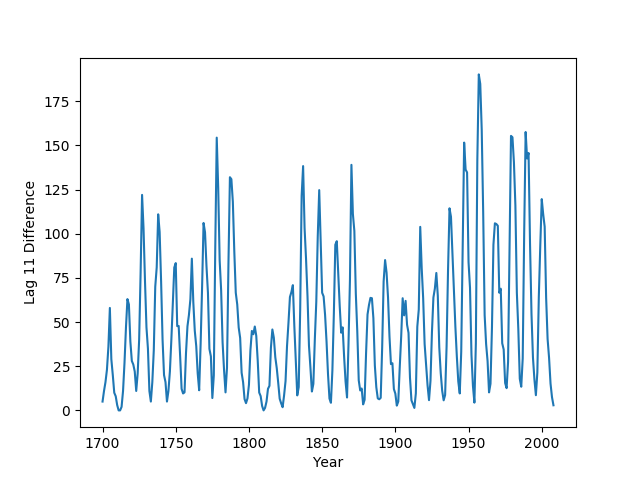

In [19]:
plt.figure()
plt.ylabel("Lag 11 Difference")
plt.xlabel("Year")
plt.plot(list(range(1700,2009)),ssdata.endog)
plt.show()

There is a well-established 11-year cycle to these counts, so in order to create an (approximately) stationary series, it makes sense to try taking the lag 11 differences. The code below will create a differenced version of the series.

In [20]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

ssdiff = difference(ssdata.endog,11)

Reconsider a plot of the data.

<IPython.core.display.Javascript object>


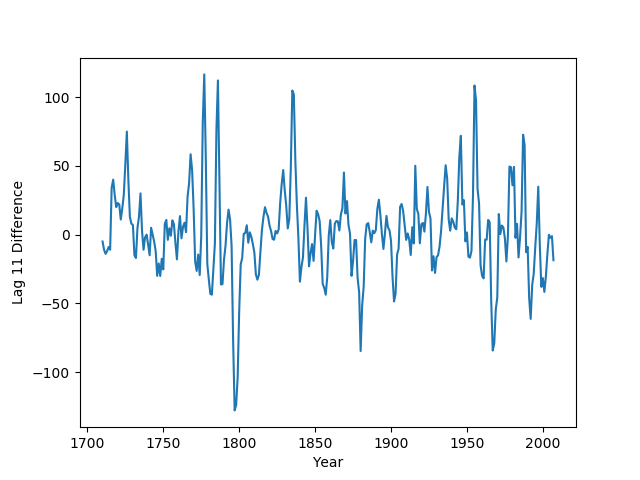

In [21]:
plt.figure()
plt.ylabel("Lag 11 Difference")
plt.xlabel("Year")
plt.plot(list(range(1710,2008)), ssdiff)
plt.show()

This is more like the behavior we expect from a stationary series. Namely, the series shows _mean reversion_, which means that the series fluctuates, but tends to return to an overall mean level.

Now let's look at the ACF of the series.

<IPython.core.display.Javascript object>


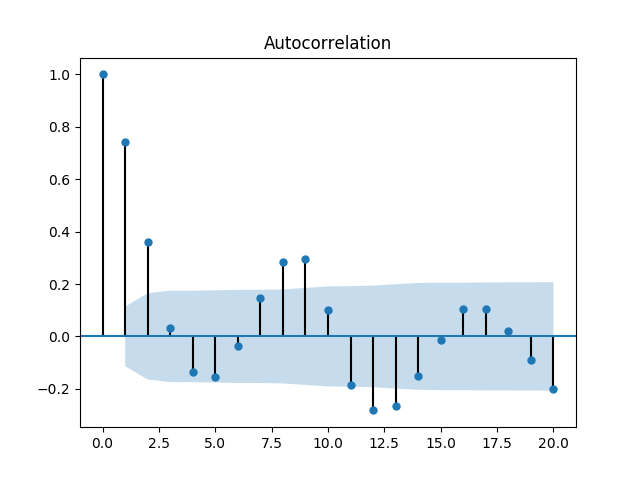

In [22]:
sm.graphics.tsa.plot_acf(ssdiff,lags=20)
plt.show()

We can fit the AR(2) model using the following syntax.

In [23]:
ssARmodel = sm.tsa.AR(ssdiff)
ssARmodelresults = ssARmodel.fit(maxlag=2, method="mle")

The parameter estimates and the value of BIC for this model is easily obtained.

In [24]:
print(ssARmodelresults.params)
print(ssARmodelresults.bic)

[ 0.49755885  1.05882407 -0.4254487 ]
6.04874117069


It is tempting to look at a plot of the actual observations versus what the model predicts (forecasts) for that observation.

<IPython.core.display.Javascript object>


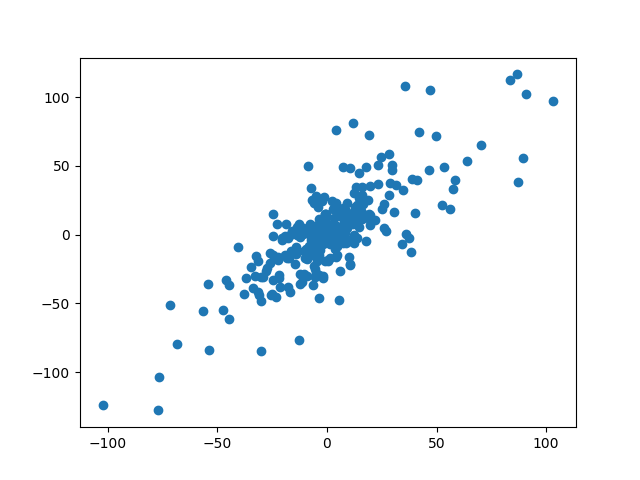

In [25]:
plt.figure()
plt.plot(ssARmodelresults.predict(),ssdiff,'o')
plt.show()

We see that there is general agreement, but it is better to construct the ACF of the residuals to determine if there is remaining correlation.

In [26]:
residuals = ssdiff - ssARmodelresults.predict()

**Problem 1a**

Construct the ACF of the residuals and comment on what you see. Does it appear that the model has accounted for all of the serial correlation in the series?

**Solution**

The code below creates the ACF of the residuals. From the plot, we can see that there is clear evidence of remaining correlation in the residuals. In other words, the fitted model has not adequately captured the serial correlation.

<IPython.core.display.Javascript object>


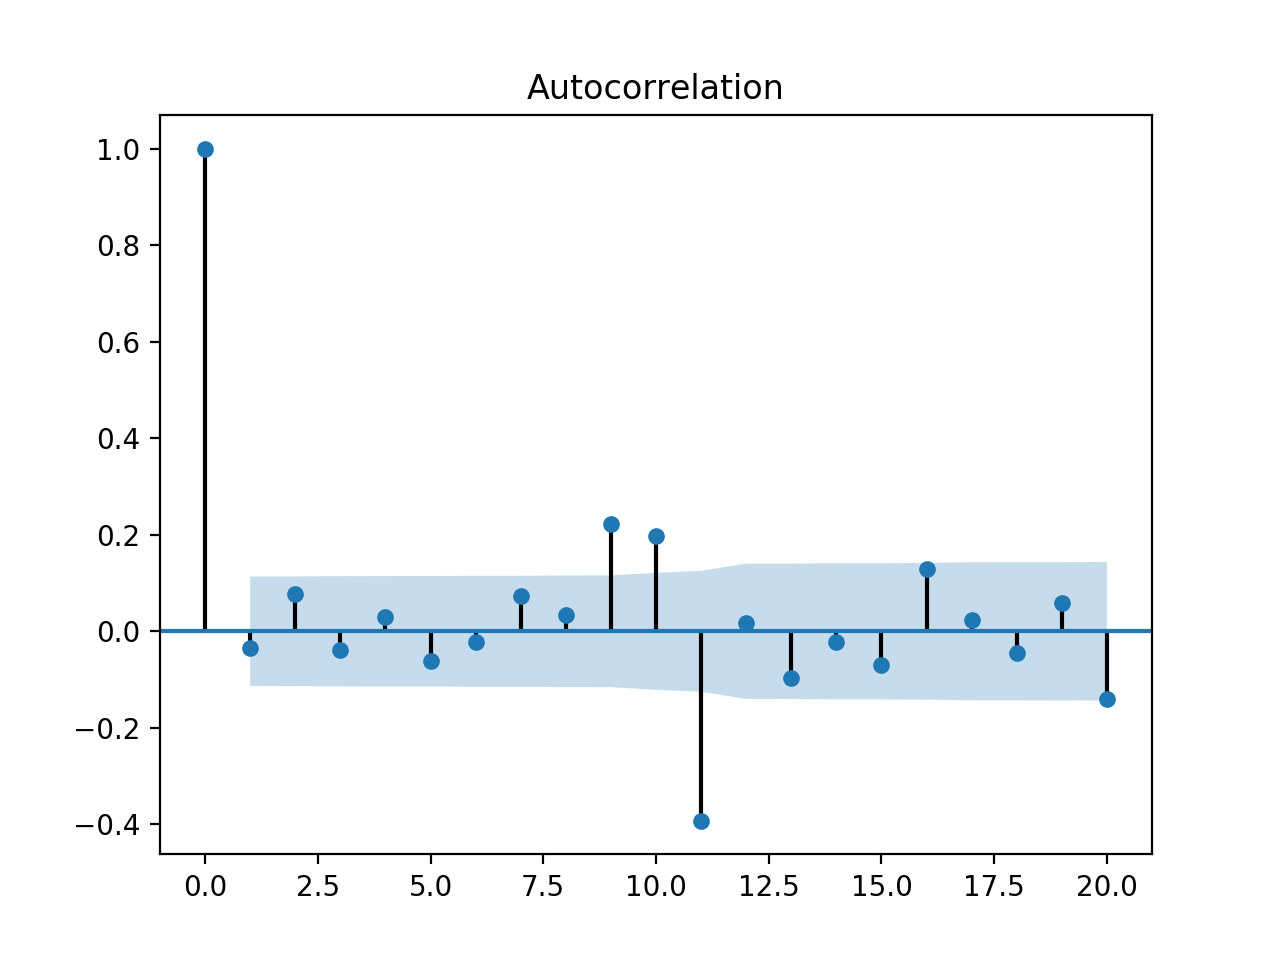

In [40]:
sm.graphics.tsa.plot_acf(residuals,lags=20)
plt.show()

**Problem 1b**

Let's consider a model of higher order. What choice of $p$ minimizes the value of BIC in this case? Be sure to work with the differenced series, not the original series. Consider values of $p$ up to 20.

**Solution**

We can simply loop over the values of $p$:

In [28]:
ssARmodel = sm.tsa.AR(ssdiff)

for p in range(1,20):
    ssARmodelresults = ssARmodel.fit(maxlag=p, method="mle")
    print(p)
    print(ssARmodelresults.bic)



1
6.23164474492
2
6.04874117069
3
6.0598117165
4
6.07670820986
5
6.09515666464
6
6.08617545667
7
6.08565103172
8
6.10355759803
9
6.12193212446
10
6.04374540821
11
6.02596503271
12
5.89924233994
13
5.88353314537
14
5.90237651903
15
5.91952628376
16
5.92839656401
17
5.93936689645
18
5.95434366278
19
5.97078136045


Or, use the built-in functionality of the method:

In [74]:
ssARmodelresults = ssARmodel.fit(maxlag=20, method="mle",ic="bic")
print(ssARmodelresults.params)

[ 0.38250041  1.06661776 -0.28111666 -0.17345634  0.16429647 -0.1570084
  0.0459765   0.12424566 -0.11471831  0.2831912  -0.06740479 -0.55959138
  0.54556138 -0.1816114 ]


In either case, we see that the best choice (as determined by BIC) is $p=13$.

## Problem 2: AR(2) in State Space Form

Study the code below taken from http://www.statsmodels.org/dev/statespace.html.

After simulating some data (stored in `endog`), it creates a Class `AR2` that fits, using a state space formulation, an AR(2) model.

- Within the `__init__` method, the number of states is specified via `k_states`. 
- The argument `k_posdef` specifies the dimension of the covariance matrix ${\bf Q}$.
- The `start_params` method returns the initial values for the parameters used in the iterative search for the MLE.
- By specifying `initialization='stationary'`, the user indicates that the initial states are assumed to be drawn from the stationary distribution of the time series.
- The matrices that make up the state space representation are specified by their names. See http://www.statsmodels.org/dev/statespace.html for a list of the possibilities.

In [47]:
# True model parameters
nobs = int(1e3)
true_phi = np.r_[0.5, -0.2]
true_sigma = 1**0.5

# Simulate a time series
np.random.seed(1234)
disturbances = np.random.normal(0, true_sigma, size=(nobs,))
endog = lfilter([1], np.r_[1, -true_phi], disturbances)

# Construct the model
class AR2(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(AR2, self).__init__(endog, k_states=2, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0]
        self['transition'] = [[0, 0],
                             [1, 0]]
        self['selection', 0, 0] = 1

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(AR2, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = params[2]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,1]  # these are very simple

# Create and fit the model
mod = AR2(endog)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                            AR2   Log Likelihood               -1389.437
Date:                Tue, 01 May 2018   AIC                           2784.874
Time:                        19:02:01   BIC                           2799.598
Sample:                             0   HQIC                          2790.470
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.4395      0.030     14.730      0.000       0.381       0.498
param.1       -0.2055      0.032     -6.523      0.000      -0.267      -0.144
param.2        0.9425      0.042     22.413      0.0

**Problem 2a**

Explain the role of the `update` method in Class `AR2` defined above.

**Solution**

The `update` method is the means by which the user specifies how the parameters come into the model matrices.

**Problem 2b**

Write out the model being fit here, both in state space form, and in a "natural" form. (It is not the same as the AR(2) model specified in the lecture notes.)

**Solution**

The model is just as the one written in the lecture notes, except that the "state intercept" model is ommitted (and hence is equal to zero). So, the model being fit here is $Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \epsilon_t$. This is sometimes called a "mean zero AR(2) model."

**Problem 2c**

Update the Class above to make the model match to the one presented during lecture. (An additional parameter is needed.)

**Solution**

In [46]:
class AR2x(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(AR2x, self).__init__(endog, k_states=2, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0]
        self['transition'] = [[0, 0],
                             [1, 0]]
        self['selection'] = [[1],[0]]
        self['state_intercept'] = [[0],[0]]

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(AR2x, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = params[2]
        self['state_intercept',0, 0] = params[3]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,1,0]
    

**Problem 2d**

Refit the simulated data using this new model. Does the value of log likelihood increase or decrease? Does the value of BIC increase or decrease? Is this surprising?

**Solution**

The fit is shown below. We note that the log likelihood has increased from -1389.437 to -1389.273 by adding this parameter. This is not at all surprising. When fitting a more complex model, the likelihood can only increase. But, we see that BIC has gone up as well, from 2799.598 to 2806.177. The implication is that the new parameter is not "important," it is not adding to the predictive ability of the model.

In [45]:
mod = AR2x(endog)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                           AR2x   Log Likelihood               -1389.273
Date:                Tue, 01 May 2018   AIC                           2786.546
Time:                        19:00:25   BIC                           2806.177
Sample:                             0   HQIC                          2794.007
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.4392      0.030     14.712      0.000       0.381       0.498
param.1       -0.2058      0.031     -6.542      0.000      -0.267      -0.144
param.2        0.9422      0.042     22.421      0.0

## Problem 3: Return to the Sunspots Data

**Problem 3a**

Try to fit the state space AR(2) model to the (differenced) sunspots data. You may encounter some challenges, but see if you can correct this problem. What is the lesson here? Use the model with the parameter added in Problem 2c above.

**Solution**

When you fit the model using the code above, you will find that it crashes. This is often an issue when trying to find the MLE in an iterative fashion, with models of such general forms. When parameters enter into a model in a consistent way, software can be written in such a way to optimize more efficiently. Here, the software has to be able to handle a wide range of situations. The price is that more issues of this sort can arise.

The class below tries starting values that gives better results.

In [48]:
class AR2x(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(AR2x, self).__init__(endog, k_states=2, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0]
        self['transition'] = [[0, 0],
                             [1, 0]]
        self['selection'] = [[1],[0]]
        self['state_intercept'] = [[0],[0]]

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(AR2x, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = params[2]
        self['state_intercept',0, 0] = params[3]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [1,-0.4,1,0.5]
    
    
mod = AR2x(ssdiff)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  298
Model:                           AR2x   Log Likelihood               -1313.313
Date:                Tue, 01 May 2018   AIC                           2634.626
Time:                        19:06:45   BIC                           2649.414
Sample:                             0   HQIC                          2640.546
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        1.0588      0.042     25.252      0.000       0.977       1.141
param.1       -0.4254      0.046     -9.243      0.000      -0.516      -0.335
param.2      392.4201     25.325     15.495      0.0

**Problem 3b**

Suppose that you believe that there is measurement error in the sunspot count. On the differenced scale, you are comfortable modelling this error as Gaussian. Incorporate this into your state space model, and then refit the model.

**Solution**

The class below implements this change by adding the observation covariance matrix.

This code also illustrates another useful technique: The variance parameters are transformed to be unconstrained. This can help with numerical issues that can arise when parameter values are close to a bound.

In [49]:
class AR2xx(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(AR2xx, self).__init__(endog, k_states=2, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0]
        self['transition'] = [[0, 0],
                             [1, 0]]
        self['selection'] = [[1],[0]]
        self['state_intercept'] = [[0],[0]]


    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(AR2xx, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = np.exp(params[2])
        self['state_intercept',0, 0] = params[3]
        self['obs_cov',0,0] = np.exp(params[4])


    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [1,-0.4,3,0.5,-1]
    
    
mod = AR2xx(ssdiff)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  298
Model:                          AR2xx   Log Likelihood               -1311.998
Date:                Tue, 01 May 2018   AIC                           2633.995
Time:                        19:11:09   BIC                           2652.481
Sample:                             0   HQIC                          2641.395
                                - 298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        1.1691      0.070     16.669      0.000       1.032       1.307
param.1       -0.5245      0.072     -7.326      0.000      -0.665      -0.384
param.2        5.7324      0.145     39.523      0.0

### The Kalman Filter

Next we will consider the Kalman Filter, and the various estimates it can create. 

First, we generate the predicted state for each time step. Note that there is a "prediction" for the initial state of zero. Then there are predictions for each of the states up and including one step beyond the final time step.

<IPython.core.display.Javascript object>


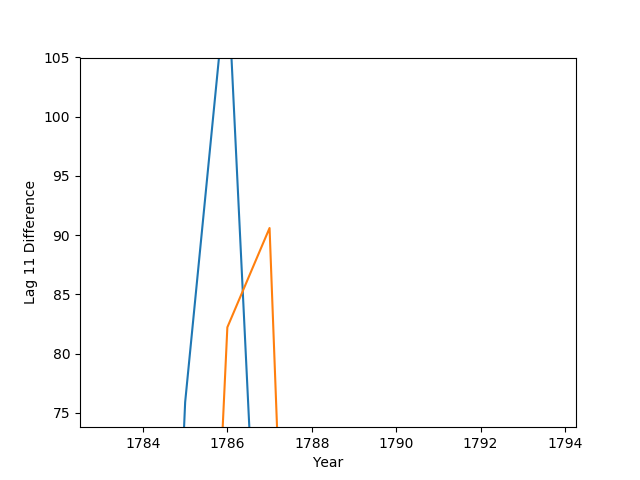

In [34]:
plt.figure()
plt.ylabel("Lag 11 Difference")
plt.xlabel("Year")
plt.plot(list(range(1710,2008)),ssdiff)
plt.plot(list(range(1710,2009)),res.smoother_results.predicted_state[0,:])
plt.show()

**Problem 3c**

If you do not zoom in on the plot, it appears as if the predictions are quite accurate. Zoom in on the plot. What is actually happening?

**Solution**

The prediction for the next state is very close to the previous value of the series. Hence, the predictions are not at all accurate.

**Problem 3d**

The following will create the filtered states. Again, zoom in on the plot and comment on the results.

**Solution**

The filtered states agree with the observations quite well. This is not surprising, given that the filtering operation uses all of the data up to and including the time point being predicted.

<IPython.core.display.Javascript object>


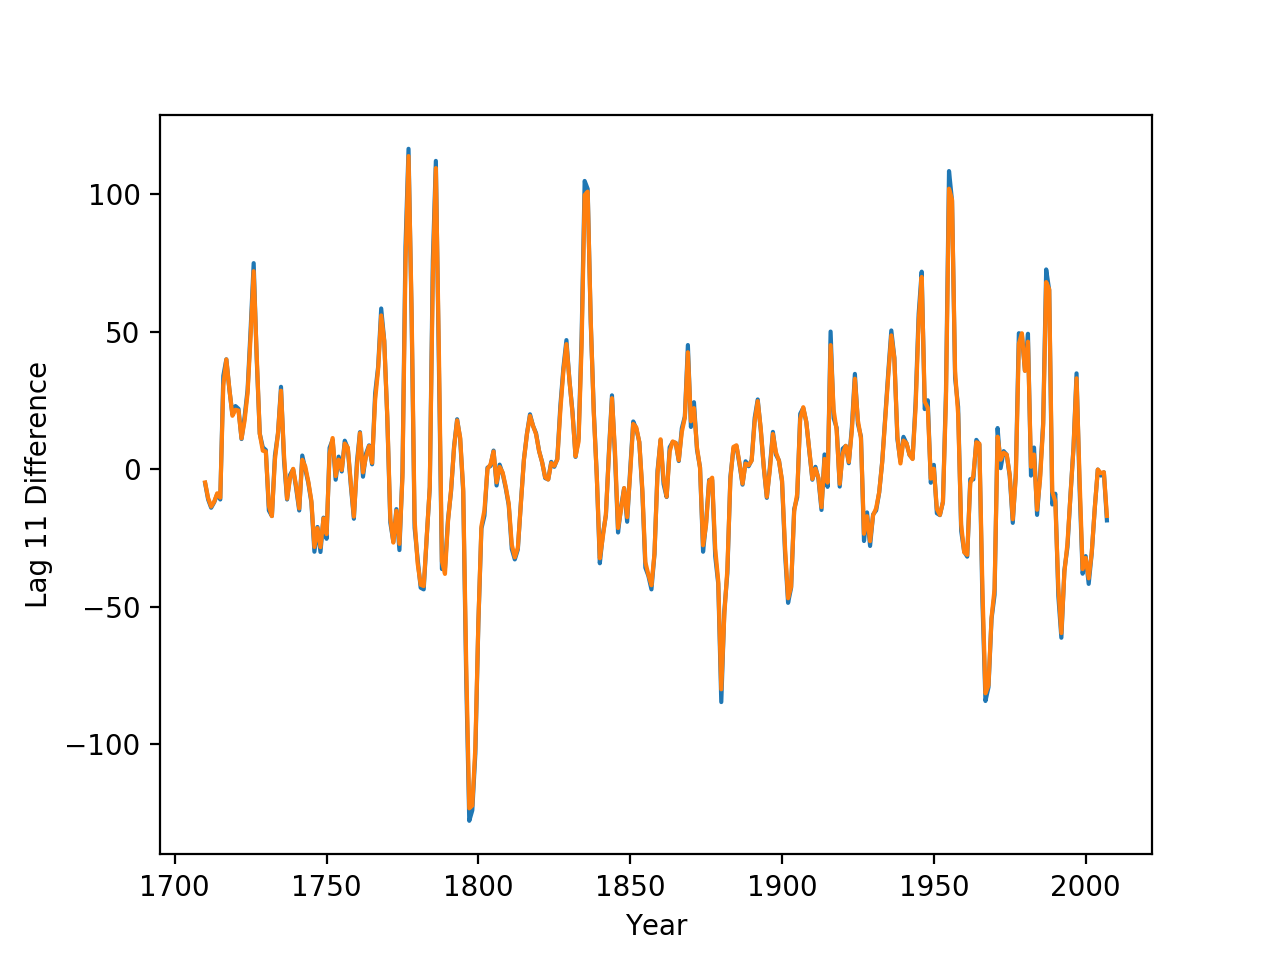

In [357]:
plt.figure()
plt.ylabel("Lag 11 Difference")
plt.xlabel("Year")
plt.plot(list(range(1710,2008)),ssdiff)
plt.plot(list(range(1710,2008)),res.smoother_results.filtered_state[0,:])
plt.show()

**Problem 3e**

Visit [this page](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.kalman_smoother.SmootherResults.html#statsmodels.tsa.statespace.kalman_smoother.SmootherResults) and write the code to find the smoothed states, and the forecasts for the future observation.
    

**Solution**

To find the smoothed states:

<IPython.core.display.Javascript object>


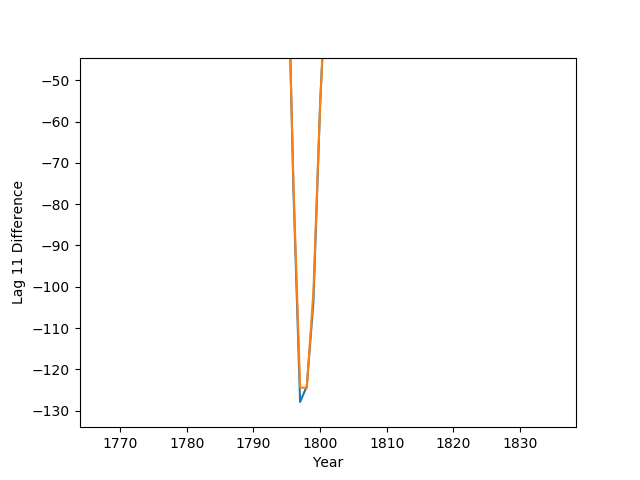

In [35]:
plt.figure()
plt.ylabel("Lag 11 Difference")
plt.xlabel("Year")
plt.plot(list(range(1710,2008)),ssdiff)
plt.plot(list(range(1710,2008)),res.smoother_results.smoothed_state[0,:])
plt.show()

And to find the forecasts for future observations:

<IPython.core.display.Javascript object>


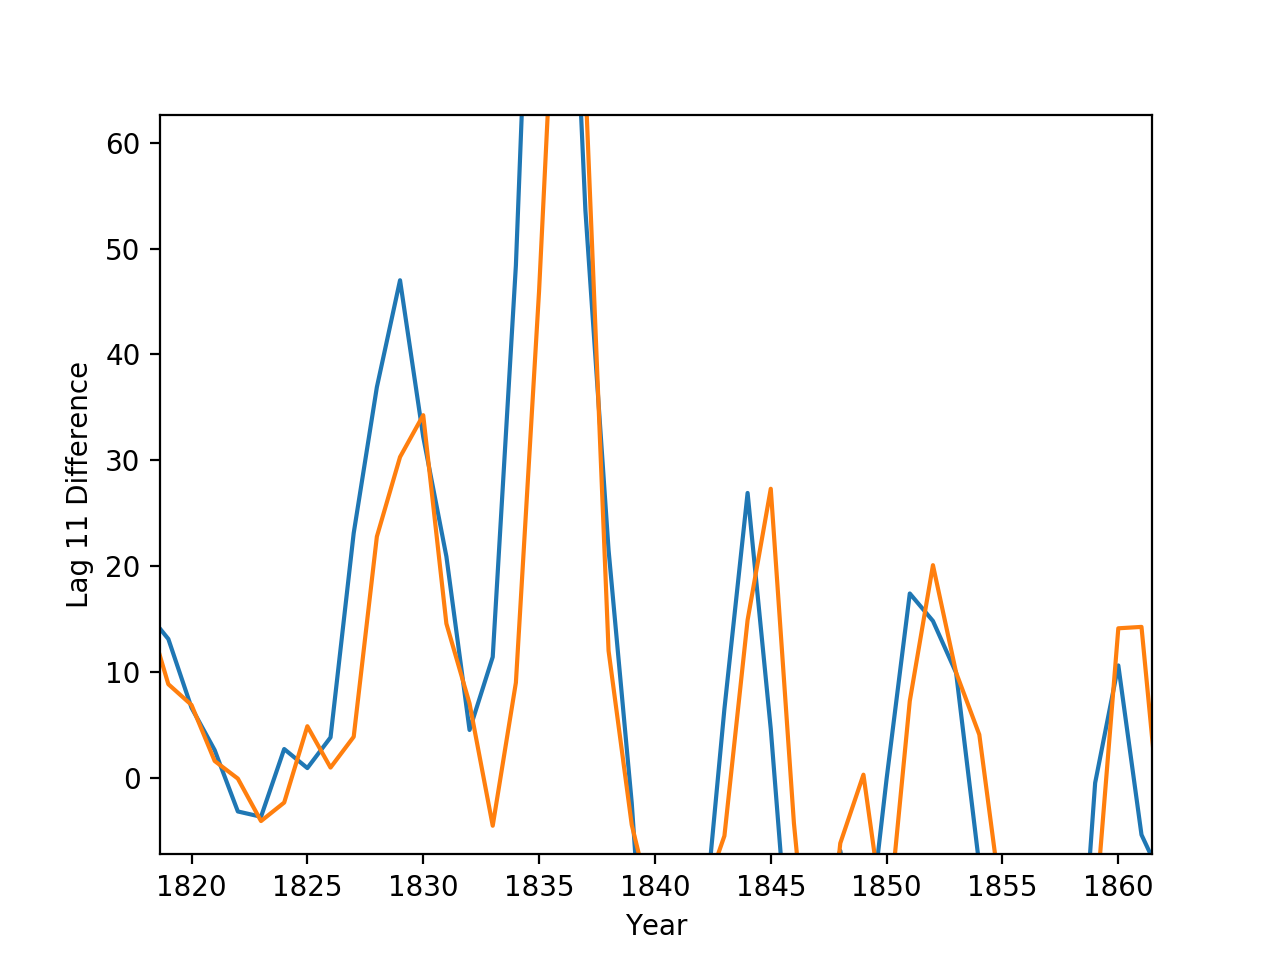

In [38]:
plt.figure()
plt.ylabel("Lag 11 Difference")
plt.xlabel("Year")
plt.plot(list(range(1710,2008)),ssdiff)
plt.plot(list(range(1710,2008)),res.smoother_results.forecasts[0,:])
plt.show()

## Challenge Problem

Write a class to implement the varying coefficient regression model described in the lecture notes.

**Solution**

The class is shown below. Note how the design matrix has a third dimension to allow for the dependence on the time index. Also, in this case, I used `initialization=approximate_diffuse`. This assumes that the initial state is drawn from a Gaussian with large entries on the covariance matrix, to indicate a great deal of uncertainty as to the values.

In [132]:
class varcoef(sm.tsa.statespace.MLEModel):
    def __init__(self, x, y):
        # Initialize the state space model
        super(varcoef, self).__init__(y, k_states=2, k_posdef=2, initialization='approximate_diffuse')

        # Setup the fixed components of the state space representation
        self['design'] = np.ones((1,2,len(x)))
        self['design',0,1,:] = x
        self['transition'] = [[1, 0],
                             [0, 1]]
        self['state_cov'] = [[0, 0],
                             [0, 0]]
        self['selection'] = [[1, 0],
                             [0, 1]]


    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(varcoef, self).update(params, transformed, **kwargs)

        self['state_cov', 0, 0] = np.exp(params[0])
        self['state_cov', 1, 1] = np.exp(params[1])
        self['obs_cov',0,0] = np.exp(params[2])


    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,0]

This is an example of the use of the class.

In [133]:
np.random.seed(0)
x = np.random.normal(0, 1, size=len(endog))
y = 10 + endog*x + np.random.normal(0, 0.2, size=len(endog))

mod = varcoef(x,y)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                        varcoef   Log Likelihood               -1199.222
Date:                Wed, 02 May 2018   AIC                           2404.444
Time:                        13:20:28   BIC                           2419.168
Sample:                             0   HQIC                          2410.040
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0      -11.7753      1.742     -6.760      0.000     -15.189      -8.361
param.1        0.1683      0.060      2.827      0.005       0.052       0.285
param.2       -2.9207      0.126    -23.093      0.0